In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
import tensorflow.keras.backend as K
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
train_dir = "../input/train/train/"
test_dir = "../input/test/test/"
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


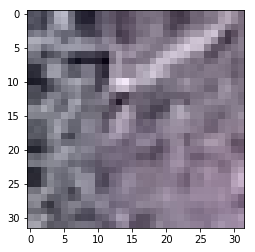

In [3]:
im = cv2.imread("../input/train/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg")
plt.imshow(im)

In [ ]:
# ResNet50_net = VGG16(weights='imagenet', 
#                      include_top=False, 
#                      input_shape=(32, 32, 3))

In [ ]:
# ResNet50_net.trainable = False
# ResNet50_net.summary()

In [ ]:
# model = Sequential()
# model.add(ResNet50_net)
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

In [4]:
from keras.layers import Conv2D, MaxPool2D, Dense, BatchNormalization, Activation, GlobalAveragePooling2D, Flatten, Dropout, LeakyReLU
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.optimizers import Adam

def baseline_model():
    model = Sequential()

    model.add(Conv2D(64, (5, 5), input_shape=(32, 32, 3), padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2D(64, (5, 5), padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    
    
    model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(GlobalAveragePooling2D())
    
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# def sigmoid(x):
    # return 1.0/(1.0 + np.exp(-x))

In [ ]:
# def binary_crossentropy(y_true, y_pred):
    # return K.mean(K.binary_crossentropy(y_true, K.sigmoid(y_pred)), axis=-1)

In [5]:
model = baseline_model()
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001), 
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
X_tr = []
Y_tr = []
imges = train_df['id'].values
for img_id in tqdm_notebook(imges):
    X_tr.append(cv2.imread(train_dir + img_id))    
    Y_tr.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
X_tr = np.asarray(X_tr)
X_tr = X_tr.astype('float32')
X_tr /= 255
Y_tr = np.asarray(Y_tr)

In [7]:
batch_size = 16
nb_epoch = 30

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset\n",
                             samplewise_center=False,  # set each sample mean to 0\n",
                             featurewise_std_normalization=False,  # divide inputs by dataset std\n",
                             samplewise_std_normalization=False,  # divide each input by its std\n",
                             zca_whitening=False,  # apply ZCA whitening\n",
                             zca_epsilon=1e-06,  # epsilon for ZCA whitening\n",
                             rotation_range=20,  # SET TO 0 IF NEEDED # randomly rotate images in 0 to 180 degrees\n",
                             width_shift_range=0.2,  # randomly shift images horizontally\n",
                             height_shift_range=0.2,  # randomly shift images vertically\n",
                             shear_range=0.2,  # set range for random shear\n",
                             zoom_range=0.2,  # set range for random zoom\n",
                             channel_shift_range=0.,  # set range for random channel shifts\n",
                             fill_mode='nearest',
                             validation_split=0.1,
                             horizontal_flip=True, 
                             vertical_flip=True)  # set mode for filling points outside the input

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_tr)

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(X_tr, Y_tr, batch_size=batch_size, subset='training'), 
                              validation_data=datagen.flow(X_tr, Y_tr, batch_size=batch_size, subset='validation'),
                              steps_per_epoch=len(X_tr) / batch_size, epochs=nb_epoch, shuffle=True, validation_steps=len(X_tr)/batch_size)

Epoch 1/15
1094/1093 [==============================] - 43s 40ms/step - loss: 0.0767 - acc: 0.9828 - val_loss: 0.1607 - val_acc: 0.9534
Epoch 2/15
1094/1093 [==============================] - 43s 39ms/step - loss: 0.0703 - acc: 0.9845 - val_loss: 0.0635 - val_acc: 0.9876
Epoch 3/15
1094/1093 [==============================] - 43s 39ms/step - loss: 0.0691 - acc: 0.9842 - val_loss: 0.2872 - val_acc: 0.9381
Epoch 4/15
1094/1093 [==============================] - 42s 39ms/step - loss: 0.0703 - acc: 0.9848 - val_loss: 0.0936 - val_acc: 0.9717
Epoch 5/15
1094/1093 [==============================] - 43s 40ms/step - loss: 0.0653 - acc: 0.9854 - val_loss: 0.1347 - val_acc: 0.9660
Epoch 6/15
 311/1093 [=======>......................] - ETA: 22s - loss: 0.0744 - acc: 0.9825

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [ ]:
%%time
X_tst = []
Test_imgs = []
for img_id in tqdm_notebook(os.listdir(test_dir)):
    X_tst.append(cv2.imread(test_dir + img_id))     
    Test_imgs.append(img_id)
X_tst = np.asarray(X_tst)
X_tst = X_tst.astype('float32')
X_tst /= 255

In [ ]:
# Prediction
test_predictions = model.predict(X_tst) # sigmoid(model.predict(X_tst))

In [ ]:
sub_df = pd.DataFrame(test_predictions, columns=['has_cactus'])

In [ ]:
sub_df['id'] = ''
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]

In [ ]:
for i, img in enumerate(Test_imgs):
    sub_df.set_value(i,'id',img)

In [ ]:
sub_df.head()

In [ ]:
sub_df.to_csv('submission.csv',index=False)